In [32]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# Defaults from 'sourmash index'

import glob
import itertools
import math
import os

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ksize = 21
moltype = 'DNA'

ignore_abundance = False
downsample = False

bf_size = 1e5
n_children = 2
scaled = False

n_neighbors = 3


from sourmash import signature as sig
from sourmash.compare import compare_all_pairs
from sourmash.index import build_sbt
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

from sourmash import umap

In [3]:
annotations = pd.read_csv('https://github.com/czbiohub/tabula-muris/raw/master/00_data_ingest/18_global_annotation_csv/annotations_facs.csv', 
                          index_col='cell')
annotations.index = annotations.index.str.replace('.', '-')
annotations.columns = annotations.columns.str.replace('.', '_')
annotations['sample_id'] = annotations.index
annotations = annotations.fillna("NA")
print(annotations.shape)
annotations.head()

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(44949, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [4]:
bladder_annotations = annotations.query('tissue == "Bladder"')
print(bladder_annotations.shape)
bladder_annotations.head()

(1378, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [5]:

folder = '/home/olga/pureScratch/olgabot-maca/facs/sourmash/'


all_signatures = glob.glob(f'{folder}/*.sig')
basenames = [os.path.basename(x) for x in all_signatures]
basenames[:10]

['A1-B000127-3_38_F-1-1_S1.sig',
 'A1-B000126-3_39_F-1-1_S289.sig',
 'A1-B000167-3_56_F-1-1_S228.sig',
 'A1-B000168-3_57_F-1-1_S177.sig',
 'A1-B000412-3_56_F-1-1_S110.sig',
 'A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B000633-3_56_F-1-1_S266.sig',
 'A1-B000634-3_56_F-1-1_S253.sig',
 'A1-B000636-3_56_F-1-1_S126.sig',
 'A1-B000826-3_39_F-1-1_S167.sig']

In [6]:
%%time

bladder_files = list(itertools.chain(*[[x for x in basenames if x.startswith(cell_id)] for cell_id in bladder_annotations.index]))
len(bladder_files)


CPU times: user 8.14 s, sys: 0 ns, total: 8.14 s
Wall time: 8.15 s


In [7]:
bladder_files[:10]

['A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B002764-3_38_F-1-1_S291.sig',
 'A1-B002771-3_39_F-1-1_S242.sig',
 'A1-D041914-3_8_M-1-1_S269.sig',
 'A1-D042253-3_9_M-1-1_S43.sig',
 'A1-MAA000487-3_10_M-1-1_S264.sig',
 'A10-B000610-3_56_F-1-1_S38.sig',
 'A10-B002764-3_38_F-1-1_S22.sig',
 'A10-B002771-3_39_F-1-1_S249.sig',
 'A10-D041914-3_8_M-1-1_S279.sig']

In [8]:
bladder_full_path = [folder + x for x in bladder_files]
print(len(bladder_full_path))
bladder_full_path[:10]

1270


['/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B000610-3_56_F-1-1_S28.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002764-3_38_F-1-1_S291.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002771-3_39_F-1-1_S242.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D041914-3_8_M-1-1_S269.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D042253-3_9_M-1-1_S43.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-MAA000487-3_10_M-1-1_S264.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B000610-3_56_F-1-1_S38.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002764-3_38_F-1-1_S22.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002771-3_39_F-1-1_S249.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-D041914-3_8_M-1-1_S279.sig']

In [9]:


# signatures = glob.glob('/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1*')
# print(f"len(signatures): {len(signatures)}")

# %time tree = build_sbt(signatures, ksize=21, moltype="DNA", scaled=False)
%time tree = build_sbt(bladder_full_path, ksize=21, moltype="DNA", scaled=False)

CPU times: user 28.6 s, sys: 360 ms, total: 28.9 s
Wall time: 29.7 s


In [10]:
sum(1 for _ in tree.leaves())

1270

In [11]:
len(tree.nodes)

2539

In [12]:
# tree.nodes

In [13]:
# [node.data for node in tree.nodes.values()]

In [14]:
similarities = pd.read_csv("/home/olga/pureScratch/olgabot-maca/facs/bladder_compare_k21_ignoreabundanceTrue.csv", index_col=0)
print(similarities.shape)
similarities.head()

(1270, 1270)


,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,1.000,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,1.000,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,1.000,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,1.000,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,1.000,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


In [15]:
series = similarities.iloc[:, 0]
series.shape

(1270,)

In [16]:
series.nlargest()

A1-B000610-3_56_F-1-1    1.000
A3-D041914-3_8_M-1-1     0.136
J9-D041914-3_8_M-1-1     0.134
M13-D041914-3_8_M-1-1    0.132
O6-D041914-3_8_M-1-1     0.128
Name: A1-B000610-3_56_F-1-1, dtype: float64

In [17]:
similarities = similarities[similarities < 1]
similarities.head()

,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,NaN,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,NaN,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,NaN,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,NaN,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,NaN,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


In [18]:
tidy = similarities.unstack().reset_index()
tidy = tidy.dropna()
tidy = tidy.rename(columns={'level_0':'cell1', 'level_1': 'cell2', 0: 'similarity'})
tidy.head()

,cell1,cell2,similarity
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.018
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.072
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.098
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.090
5,A1-B000610-3_56_F-1-1,A1-MAA000487-3_10_M-1-1,0.102


In [19]:
adjacencies_from_compare_matrix = tidy.groupby('cell1', as_index=False, group_keys=False).apply(lambda x: x.nlargest(5, 'similarity'))
print(adjacencies_from_compare_matrix.shape)
adjacencies_from_compare_matrix.head()

(6350, 3)


,cell1,cell2,similarity
59,A1-B000610-3_56_F-1-1,A3-D041914-3_8_M-1-1,0.136
800,A1-B000610-3_56_F-1-1,J9-D041914-3_8_M-1-1,0.134
979,A1-B000610-3_56_F-1-1,M13-D041914-3_8_M-1-1,0.132
1180,A1-B000610-3_56_F-1-1,O6-D041914-3_8_M-1-1,0.128
1252,A1-B000610-3_56_F-1-1,P5-D041914-3_8_M-1-1,0.126


In [46]:
import math
from pprint import pprint


def nearest_neighbors(tree, n_neighbors, ignore_abundance, downsample,
                      verbose=False):
    adjacencies = []

    n_parent_levels = math.ceil(math.log2(n_neighbors)) + 1

    # initialize search queue with top node of tree
    queue = [0]

    # while the queue is not empty, load each node and apply search
    # function.
    while queue:
        position = queue.pop(0)
        node = tree.nodes.get(position, None)

        # repair while searching.
        if node is None:
            if verbose:
                notify("repairing missing node {} ...", position, end='\r')
            if position in tree.missing_nodes:
                tree._rebuild_node(node)
                node = tree.nodes[position]
            else:
                continue

        # Add
        if isinstance(node, Leaf):
            if verbose:
                notify("Visiting {}", node.data, end='\r')
            n = 0
            upper_internal_node = tree.parent(position)
            while n < n_parent_levels:
                upper_internal_node = tree.parent(upper_internal_node.pos)
                n += 1
            leaves = tree.leaves_under(upper_internal_node.pos)

            similarities = []
            for leaf in leaves:
                # Ignore self-similarity
                if leaf == node:
                    continue
                similarity = node.data.similarity(
                    leaf.data, ignore_abundance=ignore_abundance,
                    downsample=downsample)
                # Don't filter for minimum similarity as some samples are bad
                # and don't have many neighbors, and arrays containing lists
                # of multiple sizes won't cast to int/float in numpy, so
                # similarity_adjacency_to_knn won't work on the adjacencies
                similarities.append(
                    [node.data.name(), leaf.data.name(), similarity])
#             import pdb ; pdb.set_trace()

            # take `n_neighbors` leaves with largest similarities
            adjacent = sorted(similarities, key=lambda x: x[2])[
                       -n_neighbors:]
            adjacencies.extend(adjacent)

        else:
            queue.extend(c.pos for c in tree.children(position))
    return adjacencies

In [50]:
adjacencies = nearest_neighbors(tree, n_neighbors=15,
                                  ignore_abundance=True,
                                 downsample=downsample)
print(len(adjacencies))


print(sum(1 for _ in tree.leaves()))

adjacencies_cleaned = [(u.split("_S")[0], v.split("_S")[0], weight) for u, v, weight in adjacencies]

adjacencies_from_tree = pd.DataFrame(adjacencies_cleaned, columns=['cell1', 'cell2', 'similarity'])
adjacencies_from_tree.head(20)

19050
1270


,cell1,cell2,similarity
0,D6-D042253-3_9_M-1-1,H5-D042253-3_9_M-1-1,0.132
1,D6-D042253-3_9_M-1-1,P4-MAA000487-3_10_M-1-1,0.134
2,D6-D042253-3_9_M-1-1,D5-D042253-3_9_M-1-1,0.134
3,D6-D042253-3_9_M-1-1,P9-D042253-3_9_M-1-1,0.134
4,D6-D042253-3_9_M-1-1,A7-D041914-3_8_M-1-1,0.136
5,D6-D042253-3_9_M-1-1,P5-D042253-3_9_M-1-1,0.136
6,D6-D042253-3_9_M-1-1,D3-MAA000487-3_10_M-1-1,0.138
7,D6-D042253-3_9_M-1-1,P4-D041914-3_8_M-1-1,0.138
8,D6-D042253-3_9_M-1-1,H7-D041914-3_8_M-1-1,0.140
9,D6-D042253-3_9_M-1-1,D4-MAA000487-3_10_M-1-1,0.140


In [57]:
adjacencies_from_compare_matrix.query('cell1 == "A1-B000610-3_56_F-1-1"').sort_values('similarity', ascending=False)

,cell1,cell2,similarity
59,A1-B000610-3_56_F-1-1,A3-D041914-3_8_M-1-1,0.136
800,A1-B000610-3_56_F-1-1,J9-D041914-3_8_M-1-1,0.134
979,A1-B000610-3_56_F-1-1,M13-D041914-3_8_M-1-1,0.132
1180,A1-B000610-3_56_F-1-1,O6-D041914-3_8_M-1-1,0.128
1252,A1-B000610-3_56_F-1-1,P5-D041914-3_8_M-1-1,0.126


In [56]:
adjacencies_from_tree.query('cell1 == "A1-B000610-3_56_F-1-1"').sort_values('similarity', ascending=False)

,cell1,cell2,similarity
11684,A1-B000610-3_56_F-1-1,N13-B000610-3_56_F-1-1,0.122
11683,A1-B000610-3_56_F-1-1,N1-D041914-3_8_M-1-1,0.118
11682,A1-B000610-3_56_F-1-1,N1-B000610-3_56_F-1-1,0.116
11681,A1-B000610-3_56_F-1-1,M7-B000610-3_56_F-1-1,0.110
11679,A1-B000610-3_56_F-1-1,N10-D041914-3_8_M-1-1,0.108
11680,A1-B000610-3_56_F-1-1,N12-D041914-3_8_M-1-1,0.108
11678,A1-B000610-3_56_F-1-1,M8-D041914-3_8_M-1-1,0.106
11677,A1-B000610-3_56_F-1-1,N11-D041914-3_8_M-1-1,0.102
11676,A1-B000610-3_56_F-1-1,N12-D042253-3_9_M-1-1,0.100
11674,A1-B000610-3_56_F-1-1,D12-B000610-3_56_F-1-1,0.098


In [52]:
adjacencies_from_tree.query('cell1 == "D6-D042253-3_9_M-1-1"')

,cell1,cell2,similarity
0,D6-D042253-3_9_M-1-1,H5-D042253-3_9_M-1-1,0.132
1,D6-D042253-3_9_M-1-1,P4-MAA000487-3_10_M-1-1,0.134
2,D6-D042253-3_9_M-1-1,D5-D042253-3_9_M-1-1,0.134
3,D6-D042253-3_9_M-1-1,P9-D042253-3_9_M-1-1,0.134
4,D6-D042253-3_9_M-1-1,A7-D041914-3_8_M-1-1,0.136
5,D6-D042253-3_9_M-1-1,P5-D042253-3_9_M-1-1,0.136
6,D6-D042253-3_9_M-1-1,D3-MAA000487-3_10_M-1-1,0.138
7,D6-D042253-3_9_M-1-1,P4-D041914-3_8_M-1-1,0.138
8,D6-D042253-3_9_M-1-1,H7-D041914-3_8_M-1-1,0.140
9,D6-D042253-3_9_M-1-1,D4-MAA000487-3_10_M-1-1,0.140


In [49]:
adjacencies_from_compare_matrix.query('cell1 == "D6-D042253-3_9_M-1-1"')

,cell1,cell2,similarity
402817,D6-D042253-3_9_M-1-1,C5-MAA000487-3_10_M-1-1,0.170
402911,D6-D042253-3_9_M-1-1,D7-MAA000487-3_10_M-1-1,0.162
403134,D6-D042253-3_9_M-1-1,G5-D041914-3_8_M-1-1,0.158
403047,D6-D042253-3_9_M-1-1,F3-MAA000487-3_10_M-1-1,0.154
402717,D6-D042253-3_9_M-1-1,B2-MAA000487-3_10_M-1-1,0.152


In [53]:
leaves = list(set([u for u, v, weight in adjacencies_cleaned]))
leaves[:10]

g = ig.Graph(directed=True)
g.add_vertices([u for u in leaves])  # this adds n_leaves vertices
g.add_edges([(u, v) for (u, v, weight) in adjacencies_cleaned])
g.es['weight'] = [weight for (u, v, weight) in adjacencies_cleaned]
layout = g.layout_fruchterman_reingold()
graph_embedding = np.array(layout.coords)

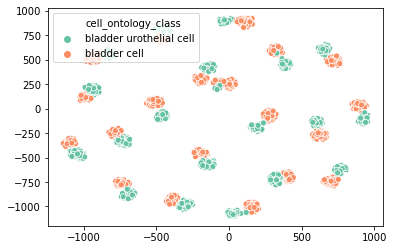

In [54]:
annotations_subset = annotations.loc[leaves]
color_col = 'cell_ontology_class'
hue = annotations_subset[color_col]

fig, ax = plt.subplots(figsize=(6, 4))

x = graph_embedding[:, 0]
y = graph_embedding[:, 1]
sns.scatterplot(x, y, hue=hue, palette='Set2')

In [25]:
adjacencies = tree.nearest_neighbors(n_neighbors=5, 
                                  ignore_abundance=True,
                                 downsample=downsample)
print(len(adjacencies))

adjacencies_cleaned = [(u.split("_S")[0], v.split("_S")[0], weight) for u, v, weight in adjacencies]

adjacencies_from_tree = pd.DataFrame(adjacencies_cleaned, columns=['cell1', 'cell2', 'similarity'])
adjacencies_from_tree.head()

6350


,cell1,cell2,similarity
0,D6-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,0.074
1,D6-D042253-3_9_M-1-1,P9-B000610-3_56_F-1-1,0.100
2,D6-D042253-3_9_M-1-1,P9-B002771-3_39_F-1-1,0.096
3,D6-D042253-3_9_M-1-1,P9-D042253-3_9_M-1-1,0.134
4,D6-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1,0.088


In [26]:
adjacencies[:5]

[['D6-D042253-3_9_M-1-1_S114', 'P8-MAA000487-3_10_M-1-1_S260', 0.074],
 ['D6-D042253-3_9_M-1-1_S114', 'P9-B000610-3_56_F-1-1_S220', 0.1],
 ['D6-D042253-3_9_M-1-1_S114', 'P9-B002771-3_39_F-1-1_S61', 0.096],
 ['D6-D042253-3_9_M-1-1_S114', 'P9-D042253-3_9_M-1-1_S52', 0.134],
 ['D6-D042253-3_9_M-1-1_S114', 'P9-MAA000487-3_10_M-1-1_S261', 0.088]]

In [236]:
# len(g.vs)

In [241]:
%%time

layout = g.layout_fruchterman_reingold(seed=0)

TypeError: matrix expected (list of sequences)

In [238]:
graph_embedding = np.array(layout.coords)
graph_embedding

array([[ 169.45001372,  642.96062043],
       [ 573.66703824, -481.09385708],
       [ 522.40989946,  129.67204534],
       ...,
       [ 836.7398416 ,  154.49219293],
       [ 718.28629691, -776.66569421],
       [  97.22610357, -365.11130354]])

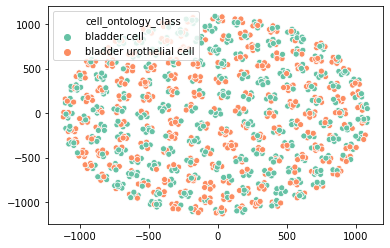

In [239]:
fig, ax = plt.subplots(figsize=(6, 4))

x = graph_embedding[:, 0]
y = graph_embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['cell_ontology_class'], palette='Set2')

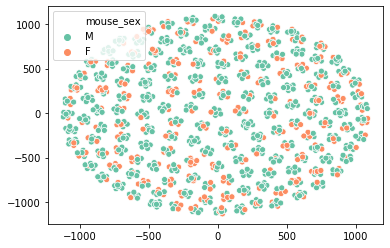

In [240]:
fig, ax = plt.subplots(figsize=(6, 4))

x = graph_embedding[:, 0]
y = graph_embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['mouse_sex'], palette='Set2')

In [ ]:
loa

In [15]:
%%time

bladder_signatures = []
for filename in bladder_full_path:
     bladder_signatures.extend(sig.load_signatures(filename, ksize=21, select_moltype="DNA"))
print(len(bladder_signatures))
bladder_signatures[:5]

1270


[SourmashSignature('A1-B000610-3_56_F-1-1_S28', 280b9bab),
 SourmashSignature('A1-B002764-3_38_F-1-1_S291', ef185816),
 SourmashSignature('A1-B002771-3_39_F-1-1_S242', 8699dd67),
 SourmashSignature('A1-D041914-3_8_M-1-1_S269', 0644e56a),
 SourmashSignature('A1-D042253-3_9_M-1-1_S43', d6f3231f)]

In [18]:
%%time

bladder_similarities_ignore_abundanceTrue = compare_all_pairs(bladder_signatures, ignore_abundance=True, n_jobs=32)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap


PicklingError: Can't pickle <class 'sourmash.signature.SourmashSignature'>: it's not the same object as sourmash.signature.SourmashSignature

In [19]:
%debug

> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/reduction.py(51)dumps()
     49     def dumps(cls, obj, protocol=None):
     50         buf = io.BytesIO()
---> 51         cls(buf, protocol).dump(obj)
     52         return buf.getbuffer()
     53 



ipdb>  dir()


['buf', 'cls', 'obj', 'protocol']


ipdb>  u


> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/connection.py(206)send()
    204         self._check_closed()
    205         self._check_writable()
--> 206         self._send_bytes(_ForkingPickler.dumps(obj))
    207 
    208     def recv_bytes(self, maxlength=None):



ipdb>  u


> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/pool.py(431)_handle_tasks()
    429                         break
    430                     try:
--> 431                         put(task)
    432                     except Exception as e:
    433                         job, idx = task[:2]



ipdb>  u


> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/pool.py(748)next()
    746         if success:
    747             return value
--> 748         raise value
    749 
    750     __next__ = next                    # XXX



ipdb>  u


> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/pool.py(325)<genexpr>()
    323                     result._set_length
    324                 ))
--> 325             return (item for chunk in result for item in chunk)
    326 
    327     def imap_unordered(self, func, iterable, chunksize=1):



ipdb>  u


> /home/olga/code/sourmash/sourmash/compare.py(204)compare_parallel()
    202     # and set the results at the appropriate combination coordinate
    203     # locations inside the similarity matrix
--> 204     for index, l in enumerate(result):
    205         startt = time.time()
    206         col_idx = index + 1



ipdb>  dir()


['_', 'chunksize', 'downsample', 'extra', 'filename', 'func', 'ignore_abundance', 'length_siglist', 'memmap_similarities', 'n_jobs', 'pool', 'result', 'siglist', 'similarities', 'start_initial']


ipdb>  d


> /home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/multiprocessing/pool.py(325)<genexpr>()
    323                     result._set_length
    324                 ))
--> 325             return (item for chunk in result for item in chunk)
    326 
    327     def imap_unordered(self, func, iterable, chunksize=1):



ipdb>  dir()


['.0']


ipdb>  print(.0)


0.0


ipdb>  q


In [20]:
%%time

bladder_similarities_ignore_abundanceTrue = compare_all_pairs(bladder_signatures, ignore_abundance=False, n_jobs=32)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap


PicklingError: Can't pickle <class 'sourmash.signature.SourmashSignature'>: it's not the same object as sourmash.signature.SourmashSignature

In [23]:
folder

'/home/olga/pureScratch/olgabot-maca/facs/sourmash/'

In [25]:
bladder_folder = f'/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder/'
! mkdir -p $bladder_folder

for sigfile in bladder_full_path:
    basename = os.path.basename(sigfile)
    new_location = f"{bladder_folder}/{basename}"
    ! ln -s $sigfile $new_location

In [61]:
from umap import UMAP

distances = 1-similarities.fillna(1)

umap_embedder = UMAP(n_neighbors=5, metric='precomputed')
umap_embedding = umap_embedder.fit_transform(distances)
print(umap_embedding.shape)
umap_embedding

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/olga/miniconda3/

(1270, 2)


array([[ 7.334929  ,  1.3565735 ],
       [ 6.271512  ,  1.9345845 ],
       [ 7.9266577 ,  2.3872454 ],
       ...,
       [-6.7024326 ,  0.85982037],
       [ 9.019495  , -0.04211347],
       [-7.414279  ,  2.7514503 ]], dtype=float32)

In [60]:
similarities

,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,NaN,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,NaN,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,NaN,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,NaN,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,NaN,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102
A1-MAA000487-3_10_M-1-1,0.102,0.020,0.106,0.100,0.114,NaN,0.096,0.062,0.114,0.114,...,0.124,0.124,0.086,0.064,0.108,0.090,0.114,0.086,0.130,0.080
A10-B000610-3_56_F-1-1,0.086,0.008,0.082,0.078,0.086,0.096,NaN,0.122,0.160,0.100,...,0.100,0.088,0.154,0.114,0.096,0.130,0.160,0.150,0.112,0.134
A10-B002764-3_38_F-1-1,0.058,0.008,0.060,0.056,0.056,0.062,0.122,NaN,0.112,0.072,...,0.060,0.056,0.104,0.098,0.062,0.096,0.106,0.108,0.060,0.084
A10-B002771-3_39_F-1-1,0.088,0.014,0.086,0.084,0.088,0.114,0.160,0.112,NaN,0.108,...,0.100,0.088,0.142,0.094,0.124,0.124,0.162,0.148,0.110,0.126
A10-D041914-3_8_M-1-1,0.096,0.018,0.126,0.100,0.106,0.114,0.100,0.072,0.108,NaN,...,0.140,0.110,0.094,0.060,0.144,0.098,0.108,0.120,0.144,0.086
